### Retrieve SDFs from directory (downloaded from Fragalysis)

In [1]:
import os
from rdkit import Chem


def get_sdfs(dir_name):
    
    sdf_files = []
    filenames = []

    # collect sdf files from dirs
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith(".sdf"):
                # ignore combined sdf file
                if 'Mpro_combined' not in file:
                    sdf_files.append(os.path.join(root, file))
                    filenames.append(file)

    return sdf_files, filenames

### Convert SDFs to rdkit mol objects

https://www.rdkit.org/docs/GettingStartedInPython.html

In [2]:
# get mol object for each sdf file

def sdf_to_mol(sdf_file_list):
   
   mols = []
   for sdf_file in sdf_file_list:
      with Chem.SDMolSupplier(sdf_file) as suppl:
         for mol in suppl:
            if mol is None: continue
            mols.append(mol)

   return mols


### Extract pharmacophores and their types and coordinates
http://rdkit.blogspot.com/2017/11/using-feature-maps.html 

In [3]:
# code to generate pharmacophores
import numpy as np
from rdkit import RDConfig, Chem
from rdkit.Chem import AllChem
from collections import defaultdict

# feature factory defines set of pharmacophore features being used 
_FEATURES_FACTORY, _FEATURES_NAMES = [], []

def get_features_factory(features_names, resetPharmacophoreFactory=False):

    global _FEATURES_FACTORY, _FEATURES_NAMES

    if resetPharmacophoreFactory or (len(_FEATURES_FACTORY) > 0 and _FEATURES_FACTORY[-1] != features_names):
        _FEATURES_FACTORY.pop()
       # _FEATURES_FACTORY.pop() # NOTE repeated line?
    if len(_FEATURES_FACTORY) == 0:
        feature_factory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
        _FEATURES_NAMES = features_names
        if features_names is None:
            features_names = list(feature_factory.GetFeatureFamilies())

        _FEATURES_FACTORY.extend([feature_factory, features_names])

    return _FEATURES_FACTORY

In [4]:
# NOTE ask re conformers here vs for query mols

def getPharmacophoreCoords(mol, features_names=["Acceptor", "Donor", "Aromatic"], confId=-1):

    # find features of a molecule
    feature_factory, keep_featnames = get_features_factory(features_names)
    rawFeats = feature_factory.GetFeaturesForMol(mol, confId=confId)
    featsDict = defaultdict(list)
    idxsDict = defaultdict(list)

    for f in rawFeats:
        if f.GetFamily() in keep_featnames:
            featsDict[f.GetFamily()].append(np.array(f.GetPos(confId=f.GetActiveConformer())))
            idxsDict[f.GetFamily()].append(np.array(f.GetAtomIds()))

    new_feats_dict = {}
    for key in featsDict:
        new_feats_dict[key] = np.concatenate(featsDict[key]).reshape((-1,3))
    
    return new_feats_dict, idxsDict


Below functions similar but slightly different:
- one gets all coordinates for all mols, to collect coordinates for fragment cloud
- the second gets coordinates for a single mol which is more useful when dealing with the query molecules

In [5]:
# compute pharmacophores coordinates
# NOTE should change just to work for one molecule rather than looping through

def get_coords(mols):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []

    for mol in mols:
        # .get() will just fill with None if key doesn't exist
        pharma_coords, __ = getPharmacophoreCoords(mol)
        donor_coord = pharma_coords.get('Donor')
        acceptor_coord = pharma_coords.get('Acceptor')
        aromatic_coord = pharma_coords.get('Aromatic')

        donor_coords.append(donor_coord)
        acceptor_coords.append(acceptor_coord)
        aromatic_coords.append(aromatic_coord)

    # remove None values
    donor_coords = [x for x in donor_coords if x is not None]
    acceptor_coords = [x for x in acceptor_coords if x is not None]
    aromatic_coords = [x for x in aromatic_coords if x is not None]

    if len(donor_coords) == 0:
        donor_coords = donor_coords
    else: 
        donor_coords = np.concatenate(donor_coords)
    
    if len(acceptor_coords) == 0:
        acceptor_coords = acceptor_coords
    else:
        acceptor_coords = np.concatenate(acceptor_coords)

    if len(aromatic_coords) == 0:
        aromatic_coords = aromatic_coords
    else:
        aromatic_coords = np.concatenate(aromatic_coords)

    return donor_coords, acceptor_coords, aromatic_coords


In [6]:
def get_coords_query(mol):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []
    
    # .get() will just fill with None if key doesn't exist
    pharma_coords, __ = getPharmacophoreCoords(mol)
    donor_coords = pharma_coords.get('Donor')
    acceptor_coords = pharma_coords.get('Acceptor')
    aromatic_coords = pharma_coords.get('Aromatic')

    # remove None values
    if donor_coords is not None:
        donor_coords = [x for x in donor_coords if x is not None]
        donor_coords = np.concatenate([donor_coords])
    if acceptor_coords is not None:
        acceptor_coords = [x for x in acceptor_coords if x is not None]
        acceptor_coords = np.concatenate([acceptor_coords])
    if aromatic_coords is not None:
        aromatic_coords = [x for x in aromatic_coords if x is not None]
        aromatic_coords = np.concatenate([aromatic_coords])

    return donor_coords, acceptor_coords, aromatic_coords

### Setting up fragment point cloud

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_coords(donor_coords, acceptor_coords, aromatic_coords):
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    # visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
    labels = ['Donor', 'Acceptor', 'Aromatic']
    for coords, label in zip([donor_coords, acceptor_coords, aromatic_coords], labels):
        if len(coords) != 0:
            ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

    plt.legend()
    
    plt.show()

    return

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


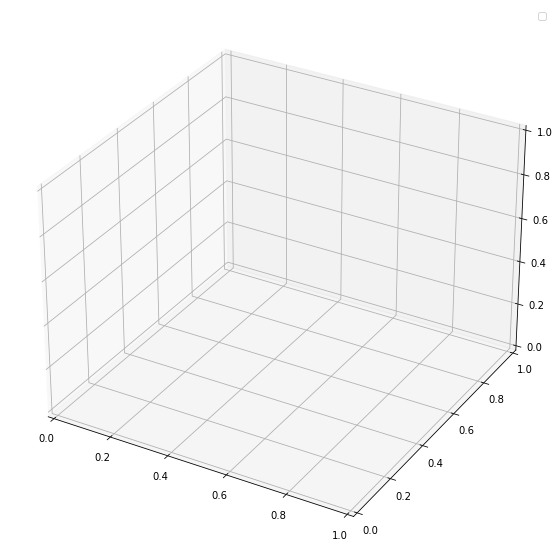

0
0


In [13]:
# run above functions
fragment_files, frag_filenames = get_sdfs('Mpro_fragments')
frag_mols = sdf_to_mol(fragment_files)
frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords = get_coords(frag_mols)
plot_coords(frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords)

# NOTE ~20 fragments, number of ph4s will obvs be different
# like 67 donors, 31 acceptors
print(len(frag_donor_coords)) 
print(len(frag_acceptor_coords))


### Setting up fragment to align against fragments (test)


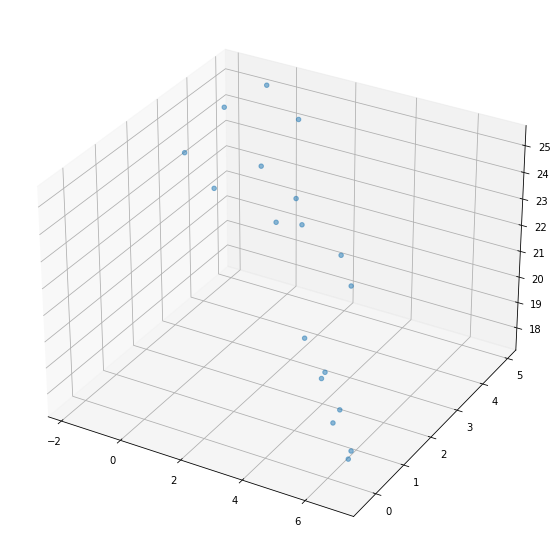

In [9]:
# just get first fragment in files
frag_test_mol = frag_mols[0]
test_donor_coords, test_acceptor_coords, test_aromatic_coords = get_coords_query(frag_mols[0])

frag_test_mol_coords = frag_mols[0].GetConformer().GetPositions()

# plot
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(frag_test_mol_coords[:,0], frag_test_mol_coords[:,1], frag_test_mol_coords[:,2], alpha=0.5)
plt.show()

Transform coordinates of the fragment test molecule:

https://en.wikipedia.org/wiki/Rotation_matrix (scroll down for 'basic rotation')

In [10]:
def rot_ar_x(radi):
    return  np.array([[1, 0, 0], 
            [0, np.cos(radi), -np.sin(radi)], 
            [0, np.sin(radi), np.cos(radi)],], 
            dtype=np.double)

def rot_ar_y(radi):
    return  np.array([[np.cos(radi), 0, np.sin(radi)], 
            [0, 1, 0], 
            [-np.sin(radi), 0, np.cos(radi)],], 
            dtype=np.double)

def rot_ar_z(radi):
    return  np.array([[np.cos(radi), -np.sin(radi), 0], 
            [np.sin(radi), np.cos(radi), 0], 
            [0, 0, 1],], 
            dtype=np.double)

frag_test_mol_coords = frag_test_mol.GetConformer().GetPositions()

# transform fragment test coords by applying rotation matrices ? 
rot_matrix_x = rot_ar_x(np.pi)
rot_matrix_y = rot_ar_y(np.pi)
rot_matrix_z = rot_ar_y(np.pi)
rot_matrices = [rot_matrix_x, rot_matrix_y, rot_matrix_z]

frag_transformed = frag_test_mol_coords@rot_matrix_x
frag_transformed_1 = frag_transformed@rot_matrix_y
frag_transformed_2 = frag_transformed_1@rot_matrix_z

print(frag_test_mol_coords[0])
print(frag_transformed_2[0])

[ 3.055  2.266 23.376]
[  3.055  -2.266 -23.376]


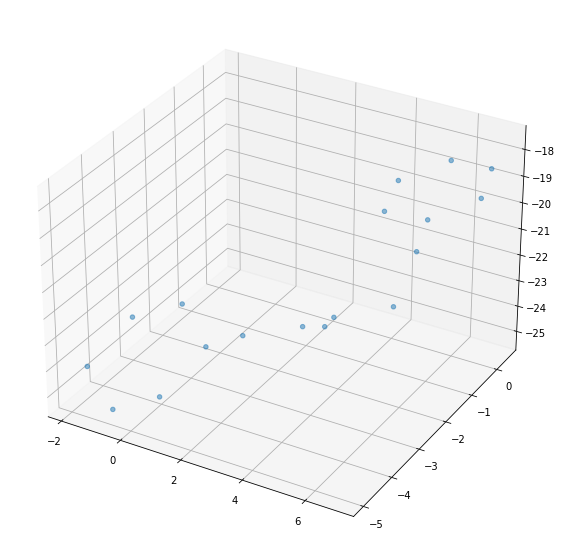

In [11]:
# plot
test_points = frag_transformed_2

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(test_points[:,0], test_points[:,1], test_points[:,2], alpha=0.5)
plt.show()

### Align transformed fragment back to fragment cloud - no pharmacophores, just using all points

In [12]:
import kabsch_functions_new as kabsch
import numpy as np
import scipy
import pandas as pd
import itertools

In [17]:
qm_means = test_points.mean(0)
frm_means = frag_test_mol_coords.mean(0)
qm_trans = test_points - qm_means
frm_trans = frag_test_mol_coords - frm_means

trans_vector =  frm_means # add to revert_translation

#For more speed use scipy.spatial.transform.Rotation.align_vectors. You still need to deal with translation
h = kabsch.compute_covariance_matrix(frm_trans, qm_trans)
r = kabsch.compute_optimal_rotation_matrix(h)
qm_rotated = kabsch.apply_rotation(qm_trans, r)

# qm_reverted, frm_reverted = revert_translation(qm_rotated, frm_trans, qm_means, frm_means)
qm_aligned =  qm_rotated + trans_vector
rmsd_val = kabsch.rmsd(qm_aligned, frm_trans+ trans_vector)

print(rmsd_val)

print('RMSD is zero when aligning transformed fragment back to same fragment:', int(rmsd_val) == 0)



1.986716795738741e-15
RMSD is zero when aligning transformed fragment back to same fragment: True


Plot result/s:


Text(0.5, 0.92, 'RMSD =0.00')

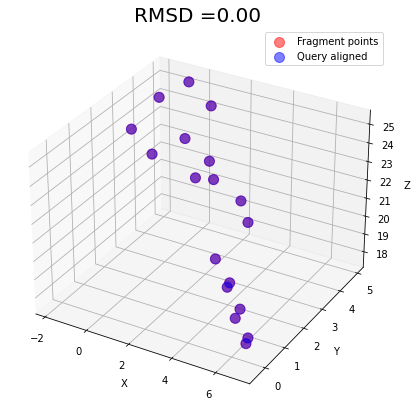

In [19]:
# plot best result/s (sometimes multiple with same RMSD)
ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
# plot matrices for comparison 
ax.scatter3D(frag_test_mol_coords[:,0], frag_test_mol_coords[:,1], frag_test_mol_coords[:,2], label='Fragment points', color='r', s=100, alpha=0.5)
ax.scatter3D(qm_aligned[:,0], qm_aligned[:,1], qm_aligned[:,2], label='Query aligned', color='b', s=100, alpha=0.5)
# set plot titles and labels
ax.legend(loc='upper right')
ax.set_xlabel('X', fontsize=10)
ax.set_ylabel('Y', fontsize=10)
ax.set_zlabel('Z', fontsize=10)
plt.title(str('RMSD =' + str("{:.2f}".format(rmsd_val))), fontsize=20)

